# Hits re-visit calibration


### Nov 2020, JAH

In [10]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [20]:
import numpy             as np
import pandas            as pd
import tables            as tb
import matplotlib.pyplot as plt

to_df = pd.DataFrame.from_records

from invisible_cities.reco import corrections as cof

In [21]:
import hipy.utils        as ut
import hipy.pltext       as pltext
import hipy.hfit         as hfit

import bes.bes           as bes
import bes.chits         as chits
import bes.pltbes        as pltbes
import bes.chits         as chits
import bes.display       as nplay

In [22]:
pltext.style()

import warnings
warnings.filterwarnings('ignore')

import time
print(' Last revision ', time.asctime())

 Last revision  Wed Dec  9 20:39:35 2020


### Code

In [23]:
get_chits_filename = chits.get_chits_filename
get_krmap_filename = chits.get_krmap_filename
get_maps           = chits.get_maps
get_hits           = chits.get_hits

#runs      = [8182, 8183, 8184]
runs      = [8182,]
sample    = 'ds'

def run_cloudsdia(runs, sample_label = 'ds'):
    """ run clouds and recompute energy
    """

    fnames  = [get_chits_filename(run, sample_label + '_rough') for run in runs]
    print(fnames)
    dfhits   = [pd.read_hdf(fname, 'CHITs.lowTh') for fname in fnames]
    dfhitHTs = [pd.read_hdf(fname, 'CHITs.highTh') for fname in fnames]


    fnames = [get_krmap_filename(run) for run in runs]
    dmaps   = [get_maps(fname) for fname in fnames]

    ddhs   = [cloudsdia(dfh, dfhHT, dmap) for dfh, dfhHT, dmap in zip(dfhits, dfhitHTs, dmaps)]

    #ddh    = bes.df_concat(ddhs, runs)

    return ddh


def cloudsdia(dfhit, dfhitHT, maps):
            
    
    def get_coorfac():
        
        vdrift    = np.mean(maps.t_evol.dv)
        print('drift velocity ', vdrift)
        _corrfac  = cof.apply_all_correction(maps, apply_temp = True,
                                        norm_strat = cof.norm_strategy.kr)
        def corrfac(x, y, z):
            dt = z/vdrif
            return _corrfact(x, y, dt)
        
        return corrfac

    
    corrfact = get_coorfac()
    
    for evt in dfhit.groupby('event'):
        
        x, y, z, eraw, erec, time = get_hits(evt, ['X', 'Y', 'Z', 'E', 'Ec', 'time'])
        
        coors = (x, y, z)
        steps = (10., 10., 2.)
        clouds.clouds(coors, steps, eraw)
        
    return
    
    


In [24]:
run_cloudsdia(runs)

['/home/hernando/data/NEW/chits_ds_rough_8182.h5']
drift velocity  0.9248098826413511


TypeError: tuple indices must be integers or slices, not str

#### filter the events only in DS-energy window

In [7]:
range_e = (1.55, 1.75) if sample == 'ds' else (2.6, 3.)

df_lt = df_lt[ut.in_range(df_lt.Ec, range_e)]
df_ht = df_ht[ut.in_range(df_ht.Ec, range_e)]

## Compare low and high hits distributions

In [8]:
print(df_ht.columns)

Index(['event', 'X', 'Y', 'Z', 'Ec', 'E', 'DZ', 'time', 'Edz', 'Ecorr',
       'Echeck', 'fgeo', 'flt', 'fdz', 'fdz_global', 'fnorma', 'Enan', 'Zmin',
       'Zmax', 'Rmax', 'run'],
      dtype='object')


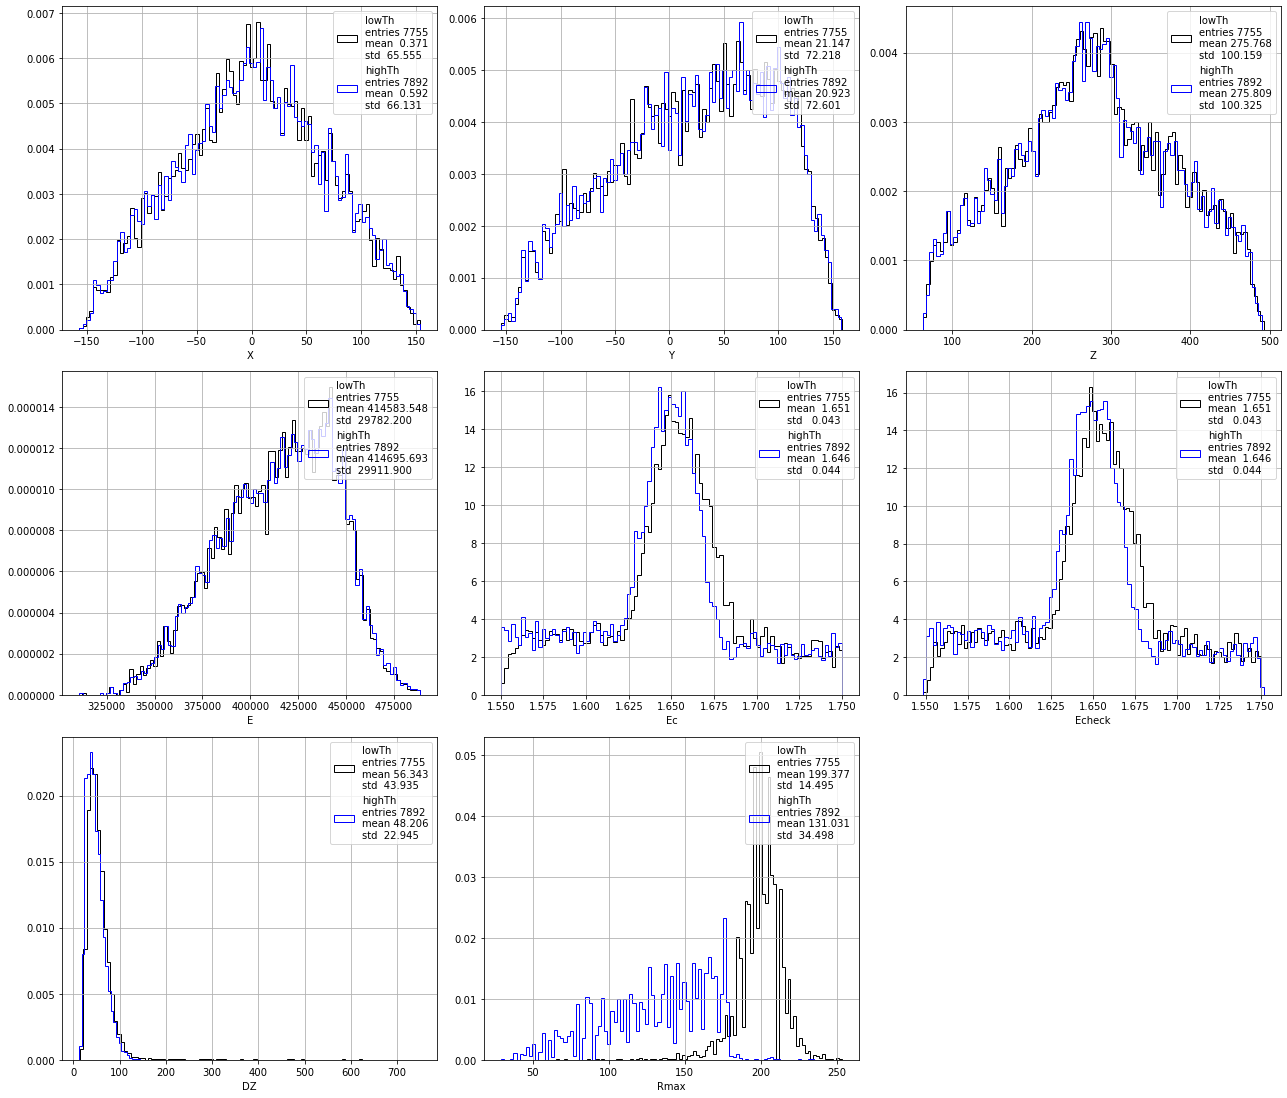

In [9]:
labels = ['X', 'Y', 'Z', 'E', 'Ec', 'Echeck', 'DZ', 'Rmax']

pltext.dfs_inspect( (df_lt, df_ht), ('lowTh','highTh'), labels = labels, ncolumns = 3)

**Conclusions:**

   * x, y, z have very similar distributions
   
   * E, is the same, but Ec (original) is different, lowhits have lower energy-corrected
   
   * Echeck is the recalibrated energy, Ec and Echeck agree for both types of hits
   
   * lowTh hits have in general smaller DZ and are at large Rmax radius! Tha tis an indication of out-of-map hits

### Check Energy- correction, compare DZ-global with DZ-local corrections

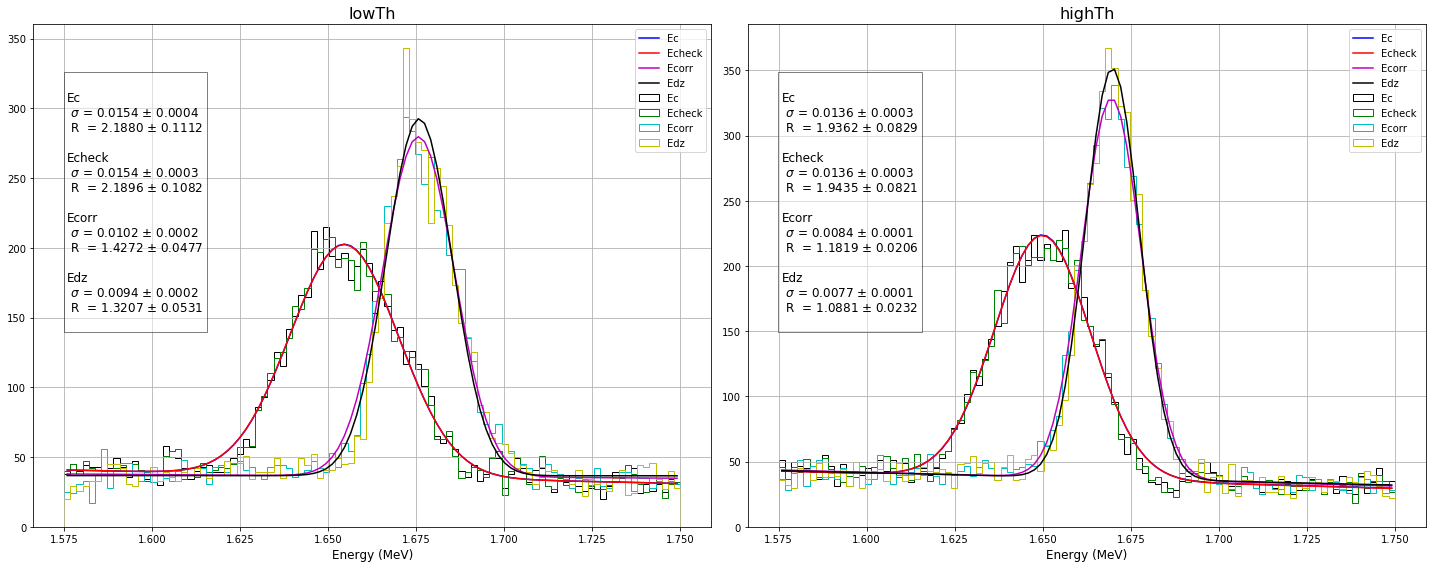

In [18]:
dfs     = (df_lt, df_ht)
dfnames = ('lowTh', 'highTh') 
bins    = 100
range_e = (1.575, 1.75) if sample == 'ds' else (2.6, 3.)

subplot = pltext.canvas(2, 2, 8, 10)

names = ['Ec', 'Echeck', 'Ecorr', 'Edz']

for i, df in enumerate(dfs):
    subplot(i + 1)
    ss = ''
    for name in names:
        si, _, _ = pltbes.pfit_energy(df[name], bins, range = range_e, formate = None, label = name)
        ss += '\n' + si
    pltext.plt_text(ss, y = 0.4, fontsize = 12);
    plt.title(dfnames[i], fontsize = 16); 
    plt.xlabel('Energy (MeV)', fontsize = 12)
plt.tight_layout()

**Conclusions:**

  * Ec and Ecorr are identical. Same corrections
  
  * Edz (global dz correction) and Ecorr (local, hit by hit, dz-corrections) are good, but global is better.
  
  * low-threshold hits have worse energy resolution thatn high-threshold. But this is due to the fact that there are out-of-map hits in lowTh!

### Let's remove nan-hits

entries in  lowTh 4673
entries in  highTh 7873


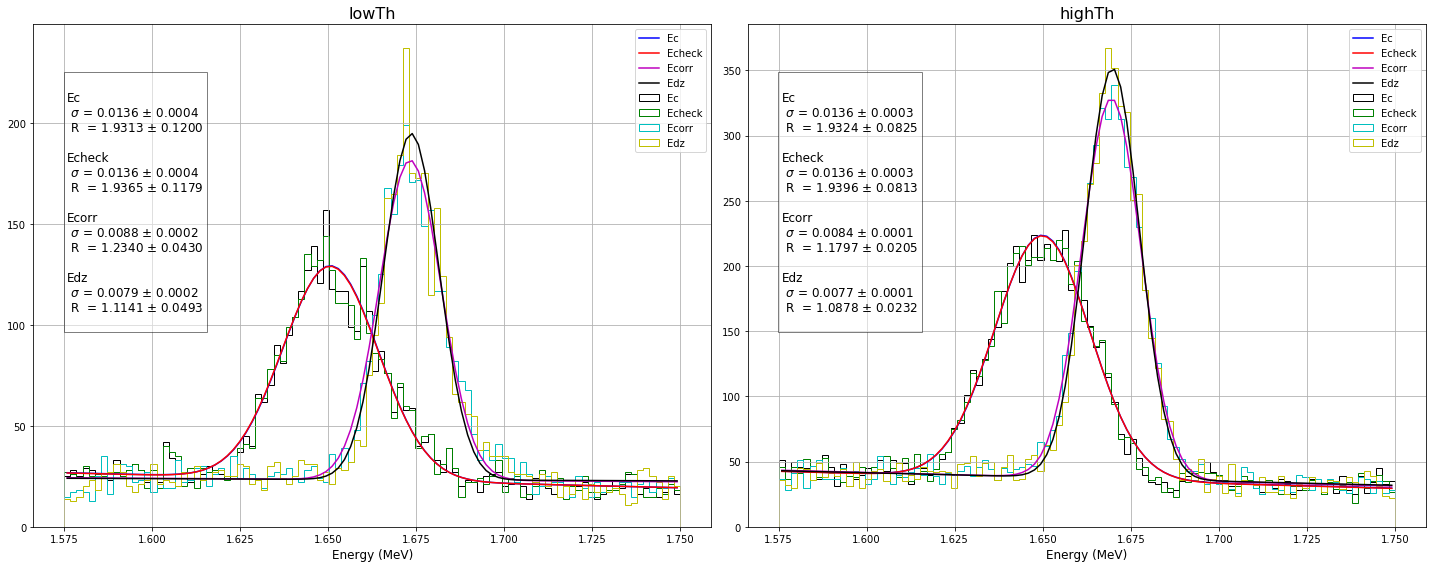

In [20]:
dfs     = (df_lt, df_ht)
dfnames = ('lowTh', 'highTh') 
bins    = 100
range_e = (1.575, 1.75) if sample == 'ds' else (2.6, 3.)

subplot = pltext.canvas(2, 2, 8, 10)

names = ['Ec', 'Echeck', 'Ecorr', 'Edz']

for i, df in enumerate(dfs):
    subplot(i + 1)
    ss = ''
    xsel = ut.in_range(df.Enan, (0, 1.e-6))
    print('entries in ', dfnames[i], np.sum(xsel))
    for name in names:
        si, _, _ = pltbes.pfit_energy(df[xsel][name], bins, range = range_e, formate = None, label = name)
        ss += '\n' + si
    pltext.plt_text(ss, y = 0.4, fontsize = 12);
    plt.title(dfnames[i], fontsize = 16); 
    plt.xlabel('Energy (MeV)', fontsize = 12)
plt.tight_layout()

**Conclusions**:
    
   * most of the energy degradation wiht low-threshold hits is due to nan-hits.
   
   * Still slightly better energy resolution with high-threshold hits.
   
   * Almost hafl of the events have out-or-map low-threshold hits.

## Compare hit-revisited energy with esmeralda Energy

In [21]:
runs   = [8182, 8183, 8184]
fnames = [bes.get_esmeralda_filename(run)  for run in runs]
dfts   = [bes.get_esmeralda_dfcomposite(fname) for fname in fnames]
dft    = bes.df_concat(dfts, runs)

In [22]:
selections, ranges = bes.get_selections_dfcomposite(dft)

In [23]:
dft.columns

Index(['event', 'trackID', 'energy', 'length', 'numb_of_voxels',
       'numb_of_hits', 'numb_of_tracks', 'x_min', 'y_min', 'z_min', 'r_min',
       'x_max', 'y_max', 'z_max', 'r_max', 'x_ave', 'y_ave', 'z_ave', 'r_ave',
       'extreme1_x', 'extreme1_y', 'extreme1_z', 'extreme2_x', 'extreme2_y',
       'extreme2_z', 'blob1_x', 'blob1_y', 'blob1_z', 'blob2_x', 'blob2_y',
       'blob2_z', 'eblob1', 'eblob2', 'ovlp_blob_energy', 'dz_track', 'enecor',
       'time', 'nS2', 'S1e', 'S2e', 'S2q', 'Nsipm', 'evt_energy', 'evt_ntrks',
       'evt_nhits', 'evt_out_of_map', 'run'],
      dtype='object')

entries in composite  4915
entries in revisit    lowTh 4673
entries in composite  8398
entries in revisit    highTh 7873


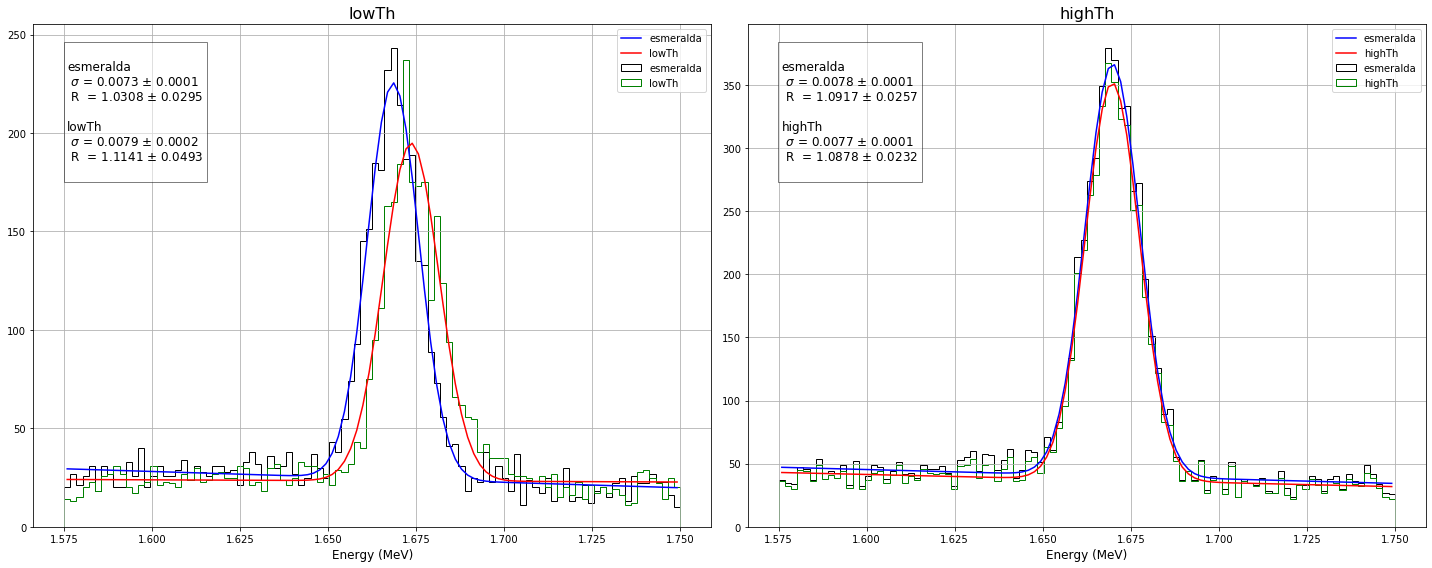

In [28]:
dfs     = (df_lt, df_ht)
dfnames = ('lowTh', 'highTh') 
bins    = 100
range_e = (1.575, 1.75) if sample == 'ds' else (2.6, 3.)

subplot = pltext.canvas(2, 2, 8, 10)

for i, df in enumerate(dfs):
    subplot(i + 1)
    ss = ''
    ysel  = ut.in_range(df.Enan, (0, 1.e-6))
    xsel  = selections.set_isin(df[ysel], name = 'isin.' + dfnames[i]+'.contained')
    print('entries in composite ', np.sum(xsel))
    print('entries in revisit   ', dfnames[i], np.sum(ysel))
    ss = ''
    si, _, _ = pltbes.pfit_energy(dft[xsel].enecor, bins, range = range_e, 
                                  formate = None, label = 'esmeralda')
    ss += '\n' + si
    si, _, _ = pltbes.pfit_energy(df [ysel].Edz   , bins, range = range_e, 
                                  formate = None, label = dfnames[i])
    ss += '\n' + si
    pltext.plt_text(ss, fontsize = 12);
    plt.title(dfnames[i], fontsize = 16); 
    plt.xlabel('Energy (MeV)', fontsize = 12)
plt.tight_layout()

**Conclusions:**

   * Esmeralda agrees with high-Th hit-revisit energy, x-check done, they are the same! 
   
   * Esmeralda is slightly better compared with hit-revisit energy for low-thresdhold hits (note tha events with out-of-map hits are removed)
   

## calibration factors


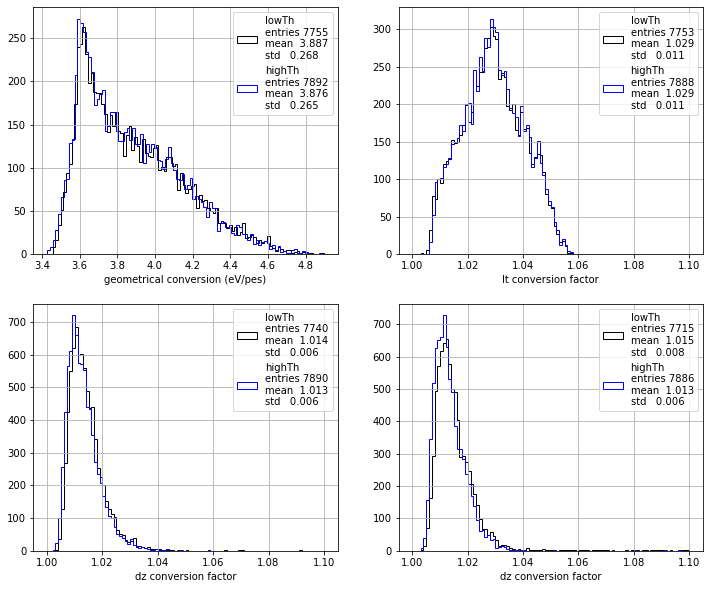

In [34]:
dfs     = (df_lt, df_ht)
dfnames = ('lowTh', 'highTh')

subplot = pltext.canvas(4)

for i, df in enumerate(dfs):
    
    ddc = df
    subplot(1)
    ddc['scale'] = 1e6
    ddc['cgeo']  = pltext.df_prod(ddc, ('fgeo', 'fnorma', 'scale'))
    ddc['ctot']  = pltext.df_prod(ddc, ('fgeo', 'fnorma', 'fdz', 'scale'))

    subplot(1)
    pltext.hist(ddc['cgeo'], 100,  label = dfnames[i]);
    plt.xlabel('geometrical conversion (eV/pes)')

    subplot(2)
    pltext.hist(ddc['flt'], 100, range = (1., 1.1), label = dfnames[i]);
    plt.xlabel('lt conversion factor');

    subplot(3)
    pltext.hist(ddc['fdz'], 100, range = (1., 1.1), label = dfnames[i]);
    plt.xlabel('dz conversion factor');

    subplot(4)
    pltext.hist(ddc['fdz_global'], 100, range = (1., 1.1), label = dfnames[i]);
    plt.xlabel('dz conversion factor');

#subplot(4)
#pltext.hist(ddc['ctot'], 100);
#plt.xlabel('conversion (eV/pes)');


**Conclusions:**

   * geometrical and life-time corrections factors are very similar for low-high threshold hits
   
   * dz-corrections (local, or global) are slightly smaller for high threshodl hits than for low ones.

## Dependences of the corrections

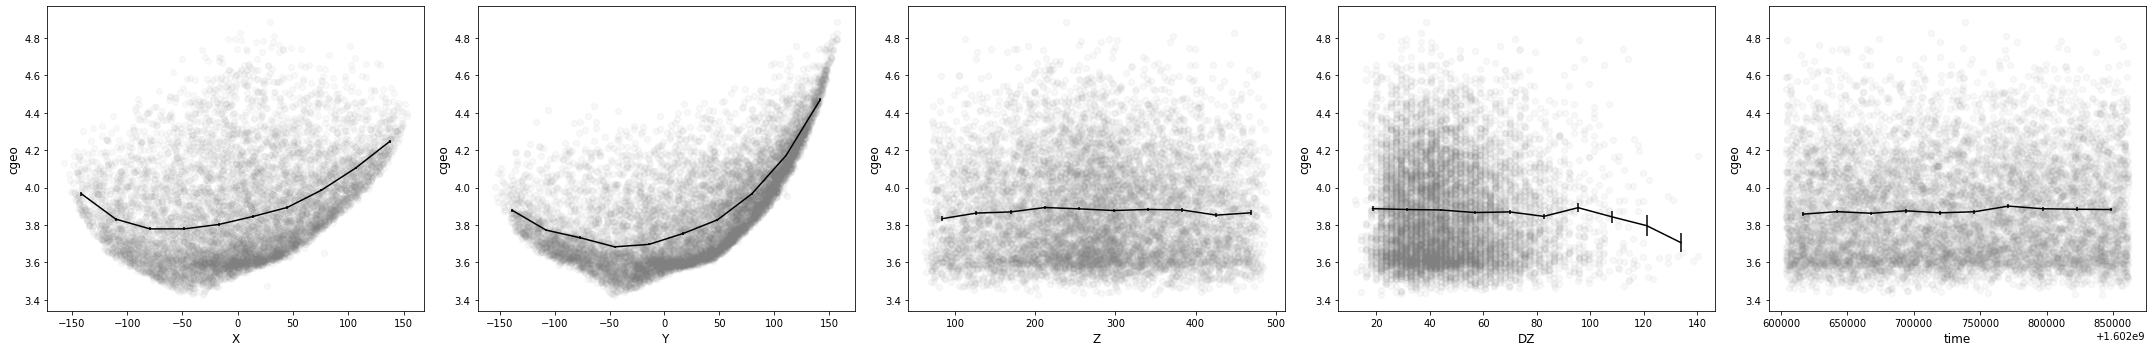

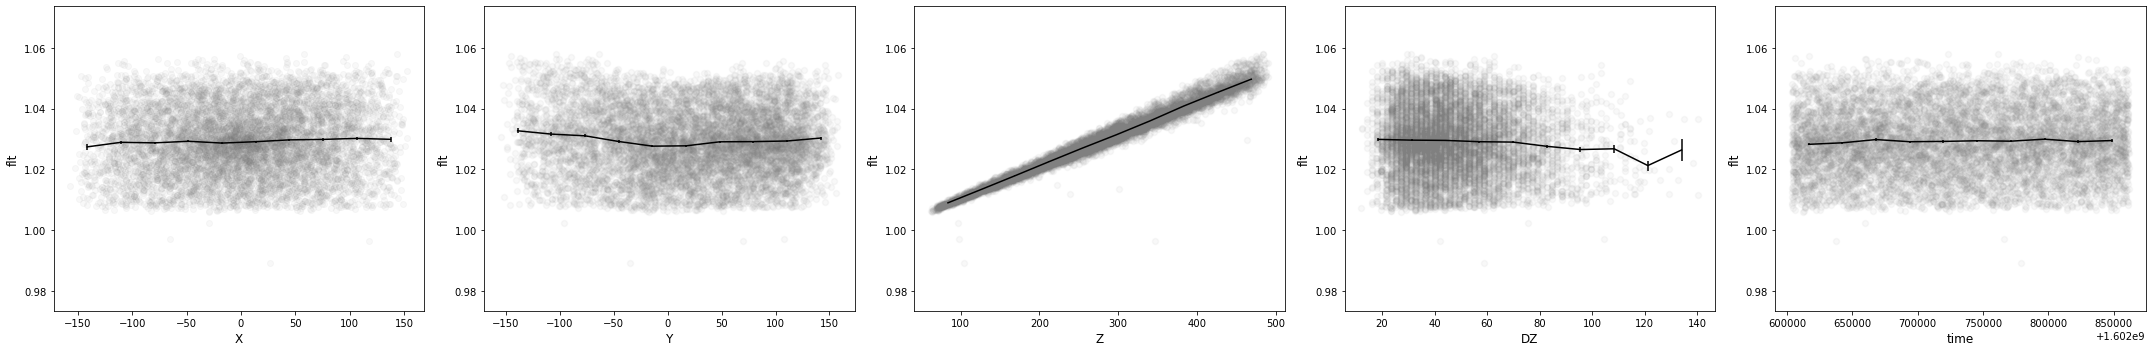

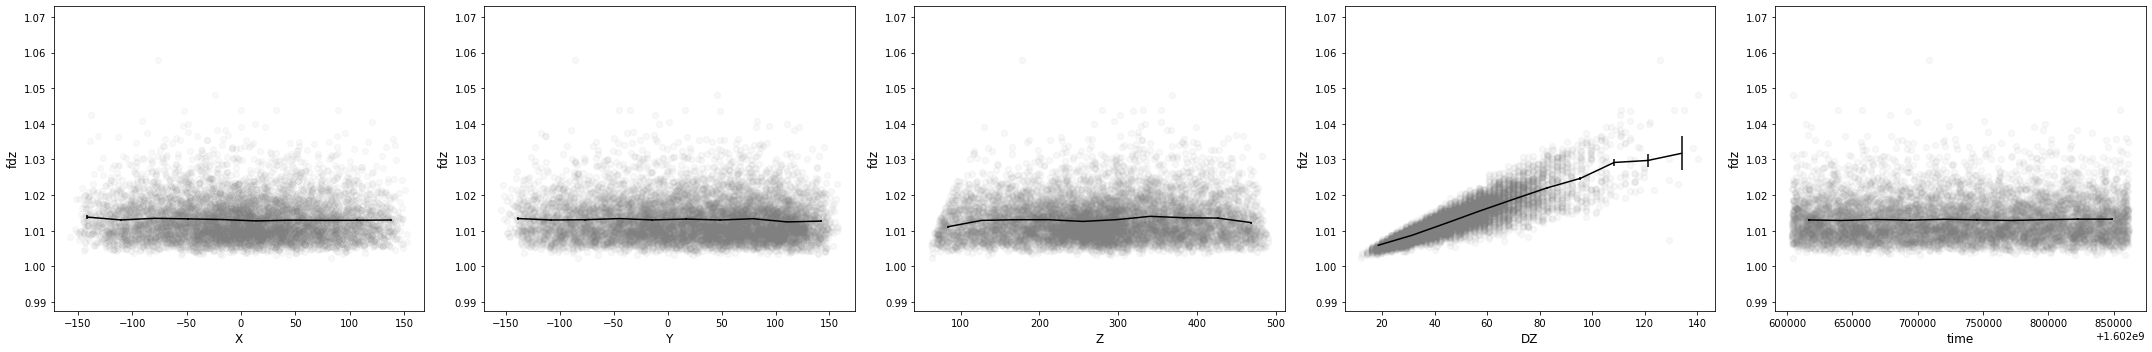

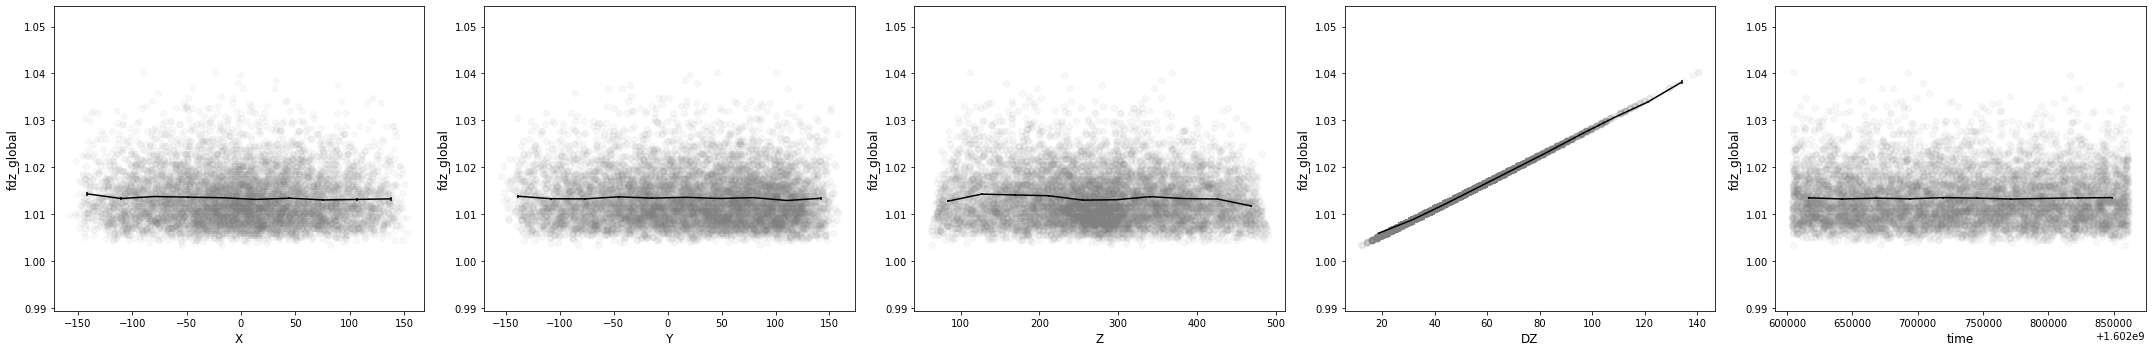

In [47]:
ddc = df_ht

xlabels = ['X', 'Y', 'Z', 'DZ', 'time']
xsel    = ut.in_range(ddc.DZ, (0., 120.)) 
names   = ['cgeo', 'flt', 'fdz', 'fdz_global']

xsel = ut.in_range(ddc.DZ, (0., 150.))

for name in names:
    pltext.df_corrprofile(ddc[xsel], name, xlabels, switch = True, alpha = 0.05)

**Conclusions:**

   * The most relevant correction is the geometrical one, with large dispersion
   
   * LT and DZ are second order corrections
   
   * DZlocal correction has some spread wiht DZ
   
   * LT correction has a second order dependence with y (vertical)
   

## Check that the corrected energy has no dependences

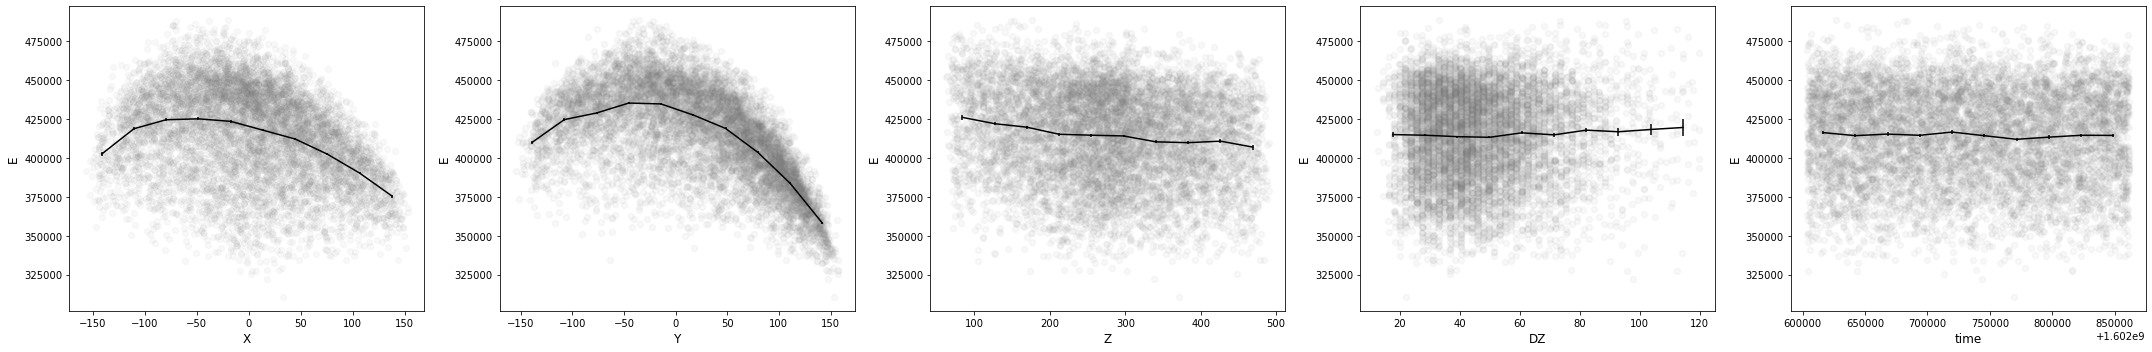

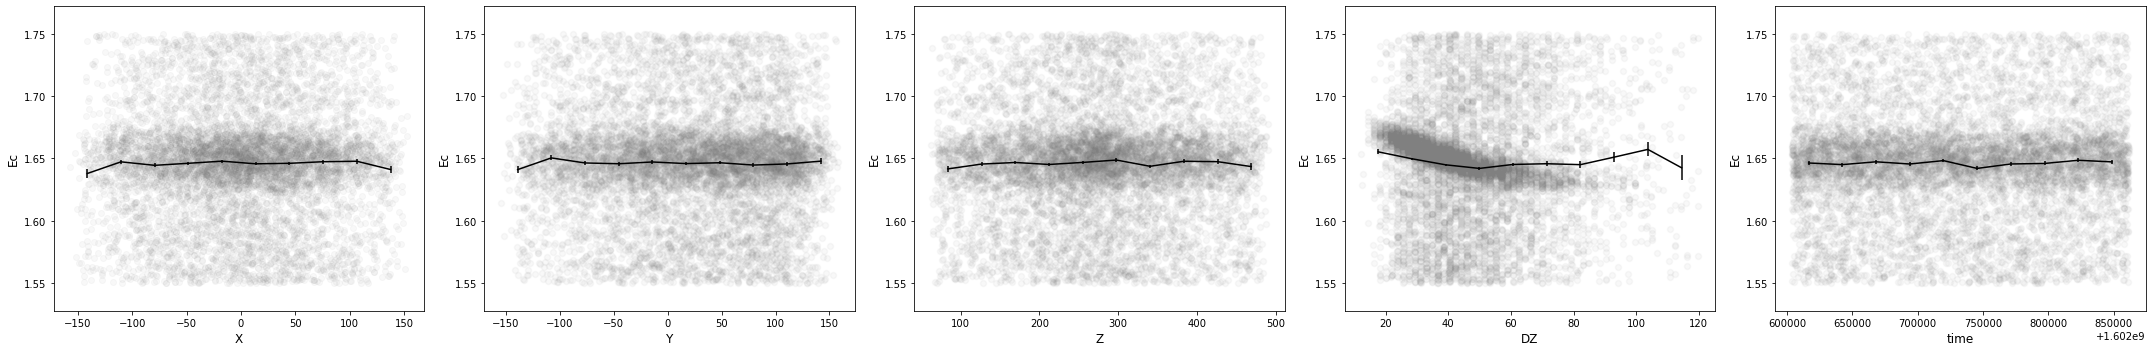

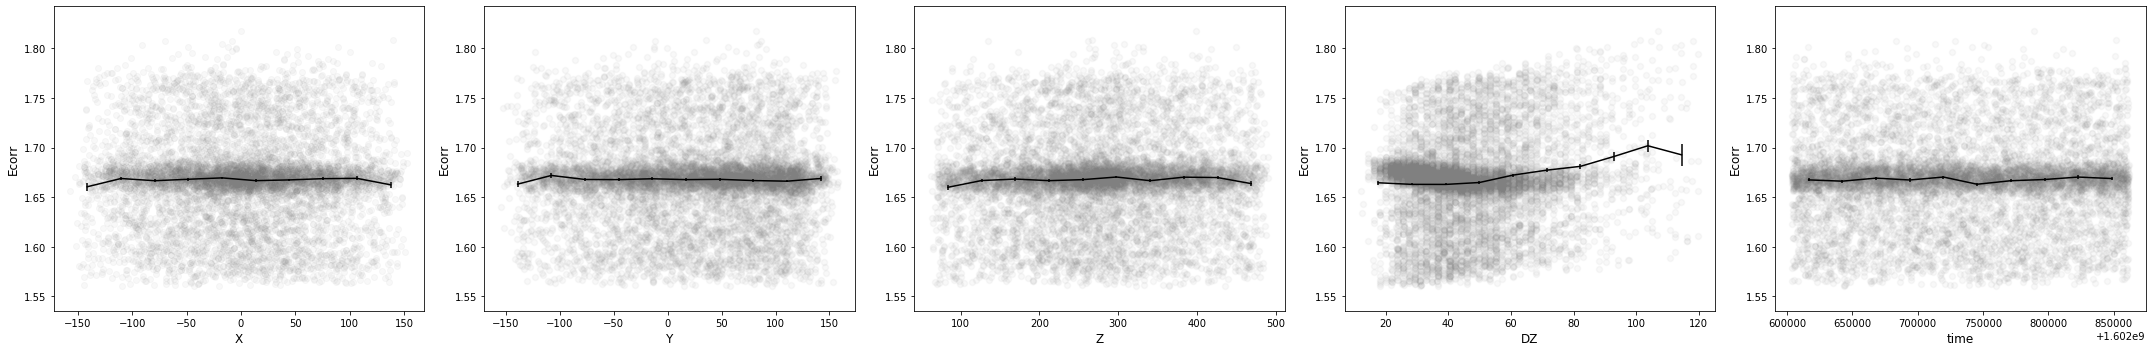

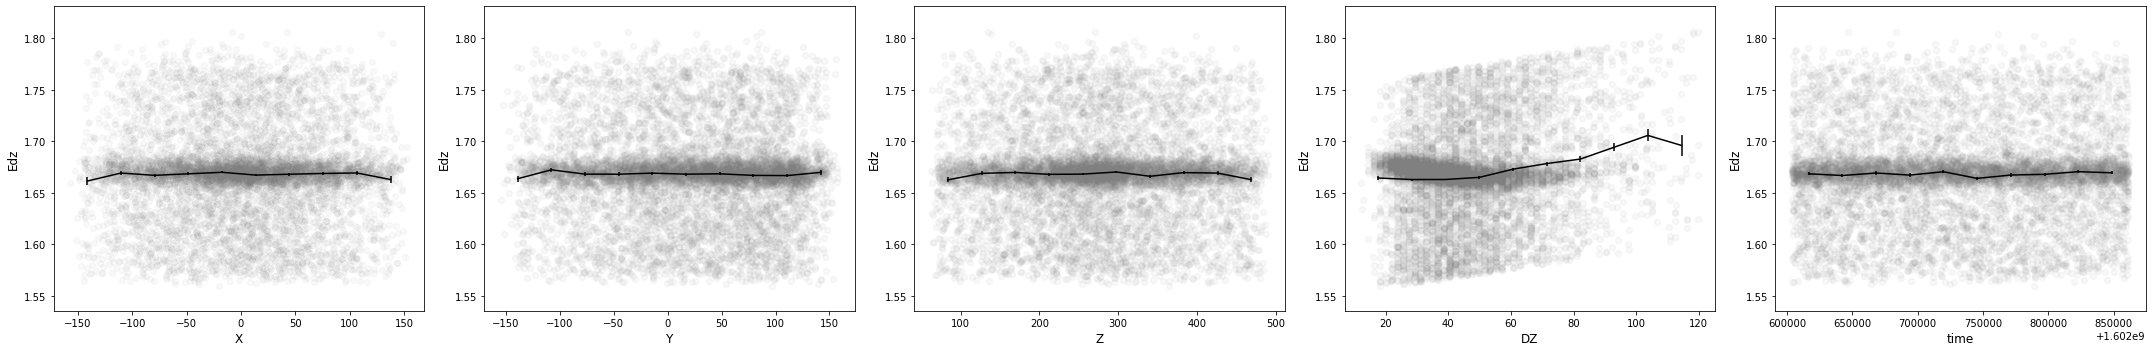

In [49]:
ddc = df_ht

xlabels = ['X', 'Y', 'Z', 'DZ', 'time']
xsel    = ut.in_range(ddc.DZ, (0., 120.)) 
names   = ['E', 'Ec', 'Ecorr', 'Edz']

xsel = ut.in_range(ddc.DZ, (0., 120.))

for name in names:
    pltext.df_corrprofile(ddc[xsel], name, xlabels, switch = True, alpha = 0.05)


**Conclusions:**
    
   * The final E-corr, E-dz (local, global delta-z correction) still have some dependences with DZ. Minor for E-coor
   
   * Notice that the selection in Ec makes an sporious correlation of Ecorr with DZ. It shows in the correlation matrix

## Energy improvement, step by step correction

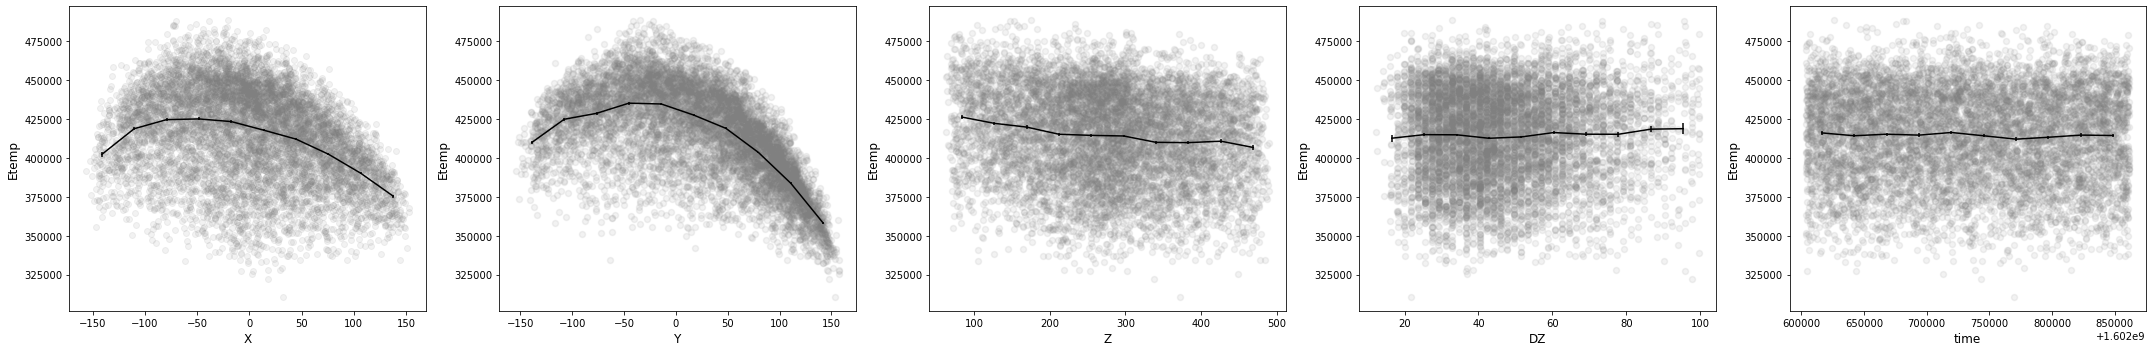

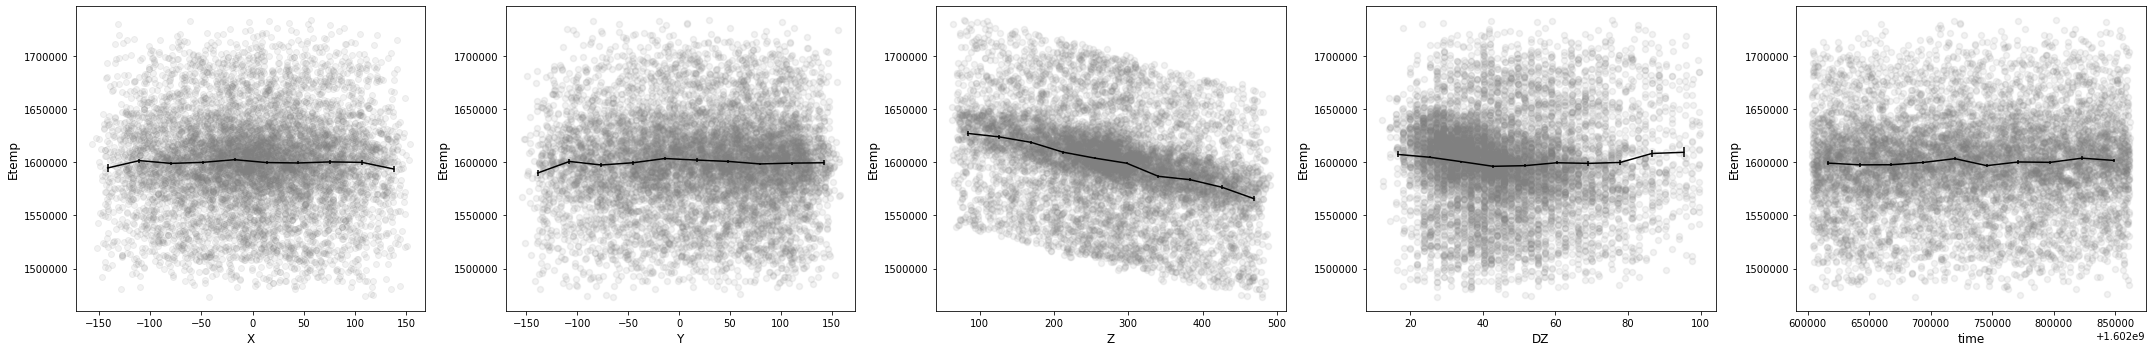

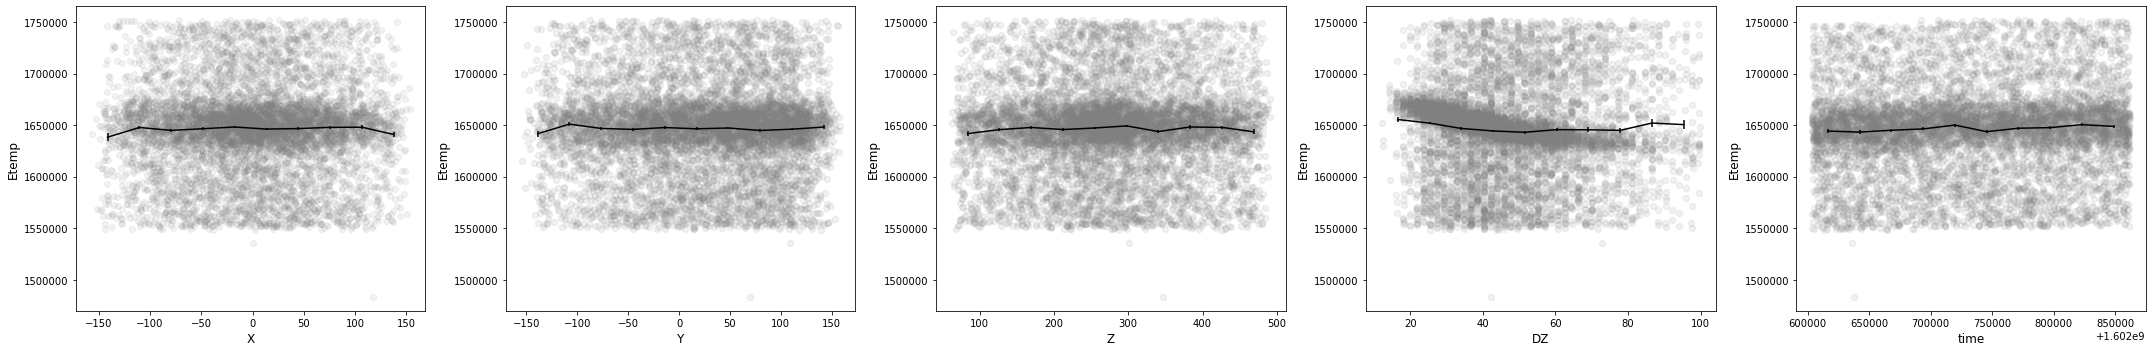

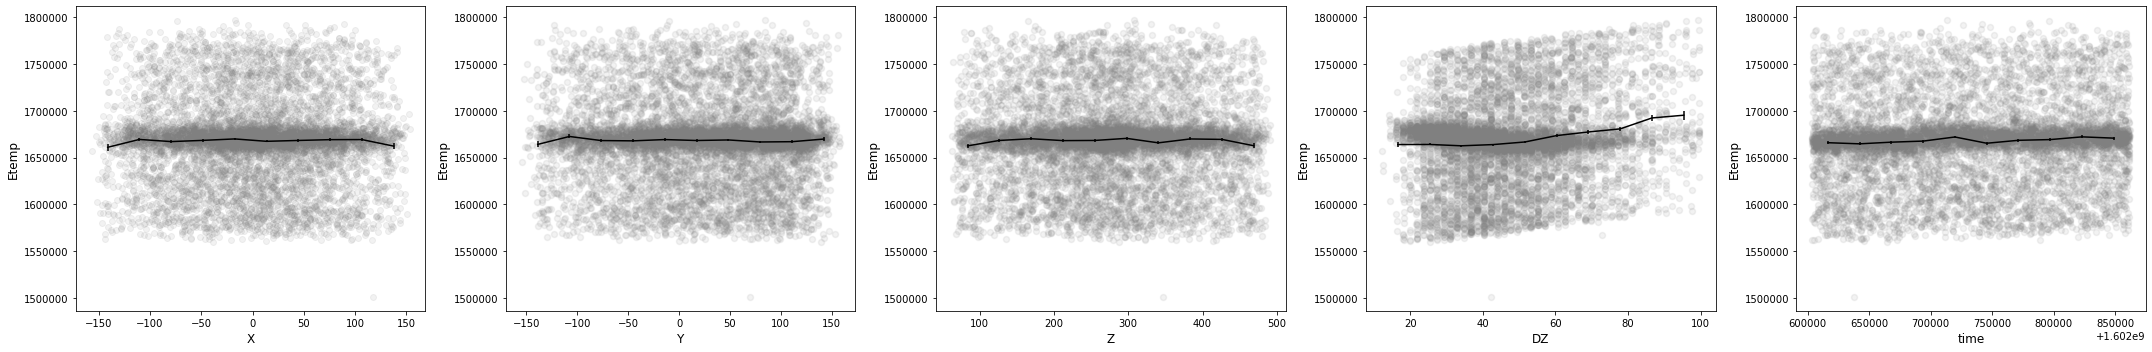

In [56]:
ddc = df_ht

xsel = ut.in_range(ddc.DZ, (0., 100))
ylabels = ['E', 'cgeo', 'flt', 'fdz_global']
xlabels = ['X', 'Y', 'Z', 'DZ', 'time']

for i in range(1, len(ylabels) + 1):
    ddc['Etemp'] = pltext.df_prod(ddc, ylabels[:i])
    pltext.df_corrprofile(ddc[xsel], 'Etemp', xlabels, switch = True)
    plt.tight_layout();


**Conclusions:**
    
   * The dz-effect is visible after applying the geometrical corrections!
   
   * dz-correction does not cure completely the dz-effect